<a href="https://colab.research.google.com/github/Azure-Blaze/mini-project-final-product/blob/main/CNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libarary

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv

import PIL.Image as Image
import os, math

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow import repeat

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import random
random.seed(666)

from pathlib import Path
import zipfile
from collections import Counter
import math
import itertools
from sklearn.metrics import confusion_matrix , classification_report
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


Download Dataset

In [ ]:
train_x_url = "http://www.nlpr.ia.ac.cn/pal/trafficdata/tsrd-train.zip"
train_x_dir = tf.keras.utils.get_file('train_imgs', origin=train_x_url,  cache_dir='.', untar=True)

train_y_url = "http://www.nlpr.ia.ac.cn/pal/trafficdata/TSRD-Train%20Annotation.zip"
train_y_dir = tf.keras.utils.get_file('y_train', origin=train_y_url,  cache_dir='.', untar=True)

test_x_url = "http://www.nlpr.ia.ac.cn/pal/trafficdata/TSRD-Test.zip"
test_x_dir = tf.keras.utils.get_file('test_imgs', origin=test_x_url,  cache_dir='.', untar=True)

test_y_url = "http://www.nlpr.ia.ac.cn/pal/trafficdata/TSRD-Test%20Annotation.zip"
test_y_dir = tf.keras.utils.get_file('y_test', origin=test_y_url,  cache_dir='.', untar=True)

32768/22024 [============================================] - 0s 6us/step


In [ ]:
x = %pwd

data_dir = Path(x)
data_dir

PosixPath('/content')

In [ ]:
from pathlib import Path
Path(str(data_dir) + "/datasets/train_imgs.tar.gz").rename(str(data_dir) + "/train_imgs.tar.gz")
Path(str(data_dir) + "/datasets/y_train.tar.gz").rename(str(data_dir) + "/y_train.txt.tar.gz")

Path(str(data_dir) + "/datasets/test_imgs.tar.gz").rename(str(data_dir) + "/test_imgs.tar.gz")
Path(str(data_dir) + "/datasets/y_test.tar.gz").rename(str(data_dir) + "/y_test.txt.tar.gz")

In [ ]:
import zipfile
with zipfile.ZipFile("train_imgs.tar.gz","r") as zip_ref:
    zip_ref.extractall("train_imgs")
with zipfile.ZipFile("y_train.txt.tar.gz","r") as zip_ref:
    zip_ref.extractall()

with zipfile.ZipFile("test_imgs.tar.gz","r") as zip_ref:
    zip_ref.extractall("test_imgs")
with zipfile.ZipFile("y_test.txt.tar.gz","r") as zip_ref:
    zip_ref.extractall()


Load Dataset

In [ ]:
train_ds = tf.data.Dataset.list_files('train_imgs/*', shuffle=True)
test_ds = tf.data.Dataset.list_files('test_imgs/*', shuffle=True)

In [ ]:
print(len(train_ds), len(test_ds))

4170 1994


In [ ]:
for file in train_ds.take(5):
    print(file.numpy())

b'train_imgs/014_1_0025.png'
b'train_imgs/037_1_0006.png'
b'train_imgs/054_1_0011.png'
b'train_imgs/006_1_0021.png'
b'train_imgs/048_1_0003.png'


In [ ]:
def get_label(file_path):
    split_1 = tf.strings.split(file_path,"/")[-1] # "/" might need to change base on how the files are seperated 
    
    return int(tf.strings.split(split_1,"_")[0])

def process_image(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path) # load the raw data from the file as a string
    img = tf.image.decode_png(img)
    img = tf.image.resize(img, [150, 150])
    return img, label

def scale(image, label):
    return image/255, label

In [ ]:
#change file path to image and label dataset
train_ds = train_ds.map(process_image)
test_ds = test_ds.map(process_image)

train_ds = train_ds.map(scale)
test_ds = test_ds.map(scale)

In [ ]:
print("train example:")
for image, label in train_ds.take(3):
    print("****Image: ",image.numpy()[0][0])
    print("****Label: ",label.numpy())

print("\ntrain example:")
for image, label in test_ds.take(3):
    print("****Image: ",image.numpy()[0][0])
    print("****Label: ",label.numpy())

train example:
****Image:  [0.7490588 0.7451372 0.7608235]
****Label:  16
****Image:  [0.21176471 0.23921569 0.23921569]
****Label:  14
****Image:  [0.4821649  0.476727   0.52375394]
****Label:  47

train example:
****Image:  [0.05098039 0.07843138 0.03921569]
****Label:  13
****Image:  [1. 1. 1.]
****Label:  2
****Image:  [0.43529412 0.42352942 0.43137255]
****Label:  13


In [ ]:
# this change the counter output into a bar chart
def counter_chart(counter):

  x=[]
  y=[]
  for i in range(len(counter)):
      x.append(counter[i][0])
      y.append(counter[i][1])

  plt.bar(x,y, align='center', alpha=0.5)
  plt.ylabel('label')
  plt.xlabel('amount')
  plt.show()


Oversampling and Augmenting Train Dataset

module from: https://www.kaggle.com/code/yihdarshieh/tutorial-oversample/notebook

labels in the original training dataset


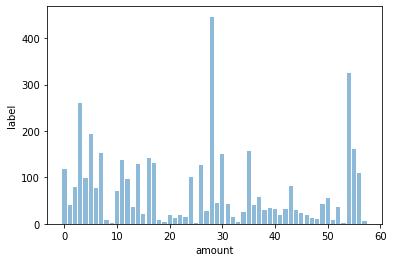

In [ ]:
label_counter = Counter()
for images, labels in train_ds:
    label_counter.update([labels.numpy()])
    
label_counting_sorted = label_counter.most_common()

print("labels in the original training dataset")
counter_chart(label_counting_sorted)

In [ ]:
TARGET_MIN_COUNTING = 440

def get_num_of_repetition_for_class(class_id):
    
    counting = label_counter[class_id]
    if counting >= TARGET_MIN_COUNTING:
        return 1.0
    
    num_to_repeat = TARGET_MIN_COUNTING / counting
    
    return num_to_repeat



In [ ]:
numbers_of_repetition_for_classes = {class_id: get_num_of_repetition_for_class(class_id) for class_id in range(58)}

print("number of repetitions for each class (if > 1)")
{k: v for k, v in sorted(numbers_of_repetition_for_classes.items(), key=lambda item: item[1], reverse=True) if v > 1}

number of repetitions for each class (if > 1)


{9: 220.0,
 25: 220.0,
 53: 220.0,
 19: 110.0,
 33: 110.0,
 57: 73.33333333333333,
 8: 55.0,
 18: 55.0,
 51: 55.0,
 48: 44.0,
 21: 36.666666666666664,
 47: 36.666666666666664,
 23: 31.428571428571427,
 32: 31.428571428571427,
 20: 24.444444444444443,
 22: 24.444444444444443,
 41: 24.444444444444443,
 46: 24.444444444444443,
 15: 20.0,
 45: 18.333333333333332,
 34: 16.923076923076923,
 27: 15.714285714285714,
 38: 14.666666666666666,
 44: 14.666666666666666,
 40: 13.75,
 42: 13.75,
 39: 12.941176470588236,
 13: 12.222222222222221,
 52: 12.222222222222221,
 1: 11.0,
 36: 11.0,
 31: 10.476190476190476,
 49: 10.476190476190476,
 29: 10.0,
 50: 7.857142857142857,
 37: 7.586206896551724,
 10: 6.285714285714286,
 6: 5.641025641025641,
 2: 5.5,
 43: 5.365853658536586,
 12: 4.583333333333333,
 4: 4.489795918367347,
 24: 4.4,
 56: 4.0,
 0: 3.7288135593220337,
 26: 3.492063492063492,
 14: 3.4375,
 17: 3.3846153846153846,
 11: 3.1884057971014492,
 16: 3.0985915492957745,
 30: 2.933333333333333,
 7

In [ ]:
keys_tensor = tf.constant([k for k in numbers_of_repetition_for_classes])
vals_tensor = tf.constant([numbers_of_repetition_for_classes[k] for k in numbers_of_repetition_for_classes])
table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), -1)

def get_num_of_repetition_for_example(training_example):
    
    _, label = training_example
    
    num_to_repeat = table.lookup(label)
    num_to_repeat_integral = tf.cast(int(num_to_repeat), tf.float32)
    residue = num_to_repeat - num_to_repeat_integral
    
    num_to_repeat = num_to_repeat_integral + tf.cast(tf.random.uniform(shape=()) <= residue, tf.float32)
    
    return tf.cast(num_to_repeat, tf.int64)

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))


def transform(image, label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = 150
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]), label

In [ ]:
def get_training_dataset_with_oversample(repeat_dataset=True, oversample=False, augumentation=False):

    dataset = train_ds

    if oversample:
        dataset = dataset.flat_map(lambda image, label: tf.data.Dataset.from_tensors((image, label)).repeat(get_num_of_repetition_for_example((image, label))))

    if augumentation:
        dataset = dataset.map(transform, num_parallel_calls=AUTO)
    
    if repeat_dataset:
        dataset = dataset.repeat() # the training dataset must repeat for several epochs
    
    dataset = dataset.shuffle(20000)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(10)
    
    return dataset

number of examples in the oversampled training dataset: 25558
labels in the oversampled training 


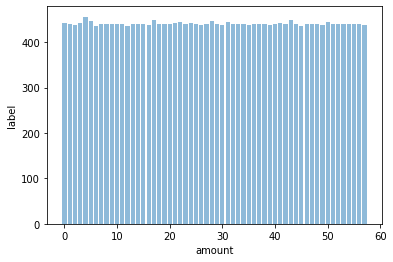

In [ ]:
oversampled_train_ds = get_training_dataset_with_oversample(repeat_dataset=False, oversample=True, augumentation=True)

label_counter_2 = Counter()
for images, labels in oversampled_train_ds:
    label_counter_2.update(labels.numpy())



label_counting_sorted_2 = label_counter_2.most_common()

NUM_TRAINING_IMAGES_OVERSAMPLED = sum([x[1] for x in label_counting_sorted_2])
print("number of examples in the oversampled training dataset: {}".format(NUM_TRAINING_IMAGES_OVERSAMPLED))

print("labels in the oversampled training ")
counter_chart(label_counting_sorted_2)

Split Test Dataset into Test and Validation Dataset

In [ ]:
val_ds = test_ds.take(int(len(test_ds)/2))
test_ds = test_ds.skip(int(len(test_ds)/2))

In [ ]:
print(len(test_ds),len(val_ds))

997 997


In [ ]:
batch_size = 32
val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [ ]:
print("training :" + str(math.ceil(NUM_TRAINING_IMAGES_OVERSAMPLED/32)) + " testing :" + str(len(test_ds)) + " validation :" + str(len( val_ds)))

training :799 testing :32 validation :32


AlexNet

In [ ]:
num_classes = 58

m = keras.models.Sequential([
  
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(150,150,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 35, 35, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 17, 17, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
m.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
m.fit(oversampled_train_ds, validation_data = val_ds, epochs=10) 

Epoch 1/10
726/726 [==============================] - 37s 28ms/step - loss: 0.2644 - accuracy: 0.9394 - val_loss: 2.3020 - val_accuracy: 0.7252
Epoch 2/10
726/726 [==============================] - 36s 28ms/step - loss: 0.2282 - accuracy: 0.9505 - val_loss: 1.5850 - val_accuracy: 0.7462
Epoch 3/10
726/726 [==============================] - 36s 27ms/step - loss: 0.2208 - accuracy: 0.9526 - val_loss: 1.3441 - val_accuracy: 0.7844
Epoch 4/10
726/726 [==============================] - 35s 27ms/step - loss: 0.1456 - accuracy: 0.9691 - val_loss: 1.9472 - val_accuracy: 0.7834
Epoch 5/10
726/726 [==============================] - 36s 28ms/step - loss: 0.1655 - accuracy: 0.9650 - val_loss: 1.9245 - val_accuracy: 0.7653
Epoch 6/10
726/726 [==============================] - 36s 28ms/step - loss: 0.1560 - accuracy: 0.9684 - val_loss: 1.8679 - val_accuracy: 0.7894
Epoch 7/10
726/726 [==============================] - 36s 28ms/step - loss: 0.1238 - accuracy: 0.9741 - val_loss: 1.8575 - val_accuracy:

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1,restore_best_weights= True)

In [ ]:
m.fit(oversampled_train_ds, validation_data = val_ds, epochs=20, callbacks = early_stop) 

Epoch 1/20
798/798 [==============================] - 39s 29ms/step - loss: 0.1120 - accuracy: 0.9834 - val_loss: 1.1906 - val_accuracy: 0.7793
Epoch 2/20
796/798 [============================>.] - ETA: 0s - loss: 0.0658 - accuracy: 0.9877

798/798 [==============================] - 39s 28ms/step - loss: 0.0664 - accuracy: 0.9876 - val_loss: 0.9615 - val_accuracy: 0.8516


Save Model

In [ ]:
#saving
!mkdir -p saved_model
m.save('saved_model/my_model')

In [ ]:
#zipping for easier export
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/keras_metadata.pb (deflated 94%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 90%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 74%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: content/saved_model/my_model/assets/ (stored 0%)
  adding: content/saved_model/Untitled.ipynb (deflated 59%)


Evaluation

In [ ]:
scores = m.evaluate(test_ds)

32/32 [==============================] - 1s 15ms/step - loss: 0.9402 - accuracy: 0.8485


In [ ]:
#true label
truth = []

for image, label in test_ds:
  for i in label.numpy():
    truth.append(i)

#predicted label
y_pred = m.predict(test_ds)
prediction = [np.argmax(element) for element in y_pred]

In [ ]:
#taking mislabeled data position
error_pos = []
count = 0

for i in range(len(truth)):
  if truth[i] != prediction[i]:
    error_pos.append(i)
  count += 1
  if count == 32: #batch size is 32
    break



Plot Result

Code Module:https://github.com/codebasics/potato-disease-classification/blob/main/training/potato-disease-classification-model.ipynb

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    confidence = round(100 * (np.max(predictions[0])), 2)
    return np.argmax(predictions[0]), confidence

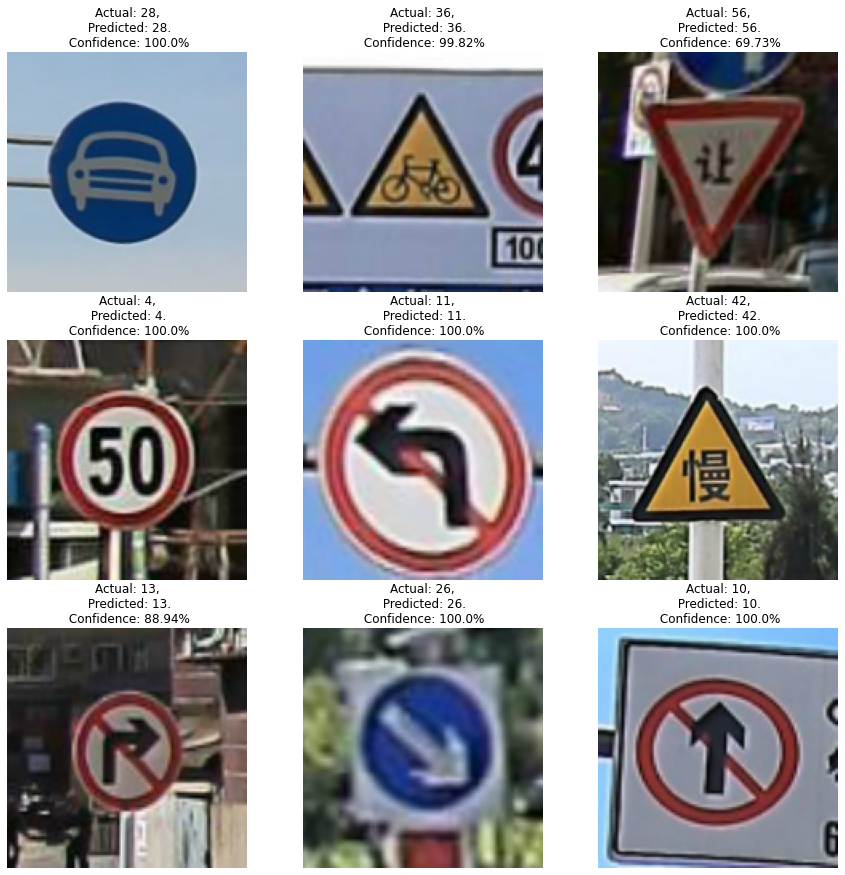

In [ ]:
#first 9 result
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        
        predicted_class, confidence = predict(m, images[i].numpy())
        actual_class = truth[i] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

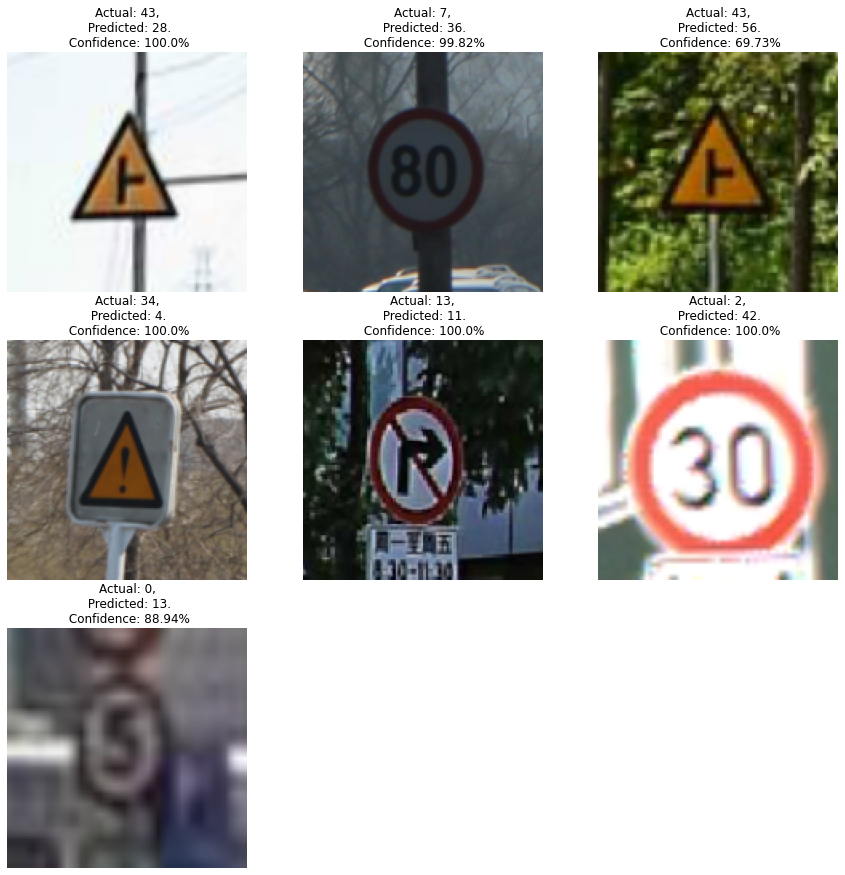

In [ ]:
#first 9 errors in batch 1
x = len(error_pos)

if x > 10:
  x = 9

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(x):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[error_pos[i]].numpy())
        
        predicted_class, confidence = predict(m, images[error_pos[i]].numpy())
        actual_class = truth[error_pos[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
#this take all mislabels 
error_pos = []
count = 0

for i in range(len(truth)):
  if truth[i] != prediction[i]:
    error_pos.append(i)

[[43 15]
 [17 15]
 [ 7 13]
 [ 2 13]
 [13 11]
 [38 11]
 [11  8]
 [26  7]
 [ 5  5]
 [52  5]
 [50  5]
 [21  5]
 [28  5]
 [34  4]
 [39  4]
 [ 4  3]
 [30  3]
 [49  3]
 [35  2]
 [10  2]
 [44  2]
 [37  2]
 [15  2]
 [ 0  1]
 [16  1]
 [24  1]
 [54  1]
 [22  1]
 [ 3  1]]


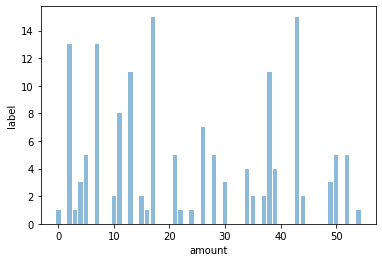

In [ ]:
error_counter = Counter()

for i in range(len(truth)):

  if i in error_pos:
    error_counter[truth[i]] += 1

error_counter = error_counter.most_common()

print(np.array(error_counter))
counter_chart(error_counter)

Confustion Matrix

code from:https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(17, 17))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = [*range(58)]

Confusion matrix, without normalization
[[ 7  0  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ... 31  0  0]
 [ 0  0  0 ...  0 16  0]
 [ 0  0  0 ...  0  0  4]]


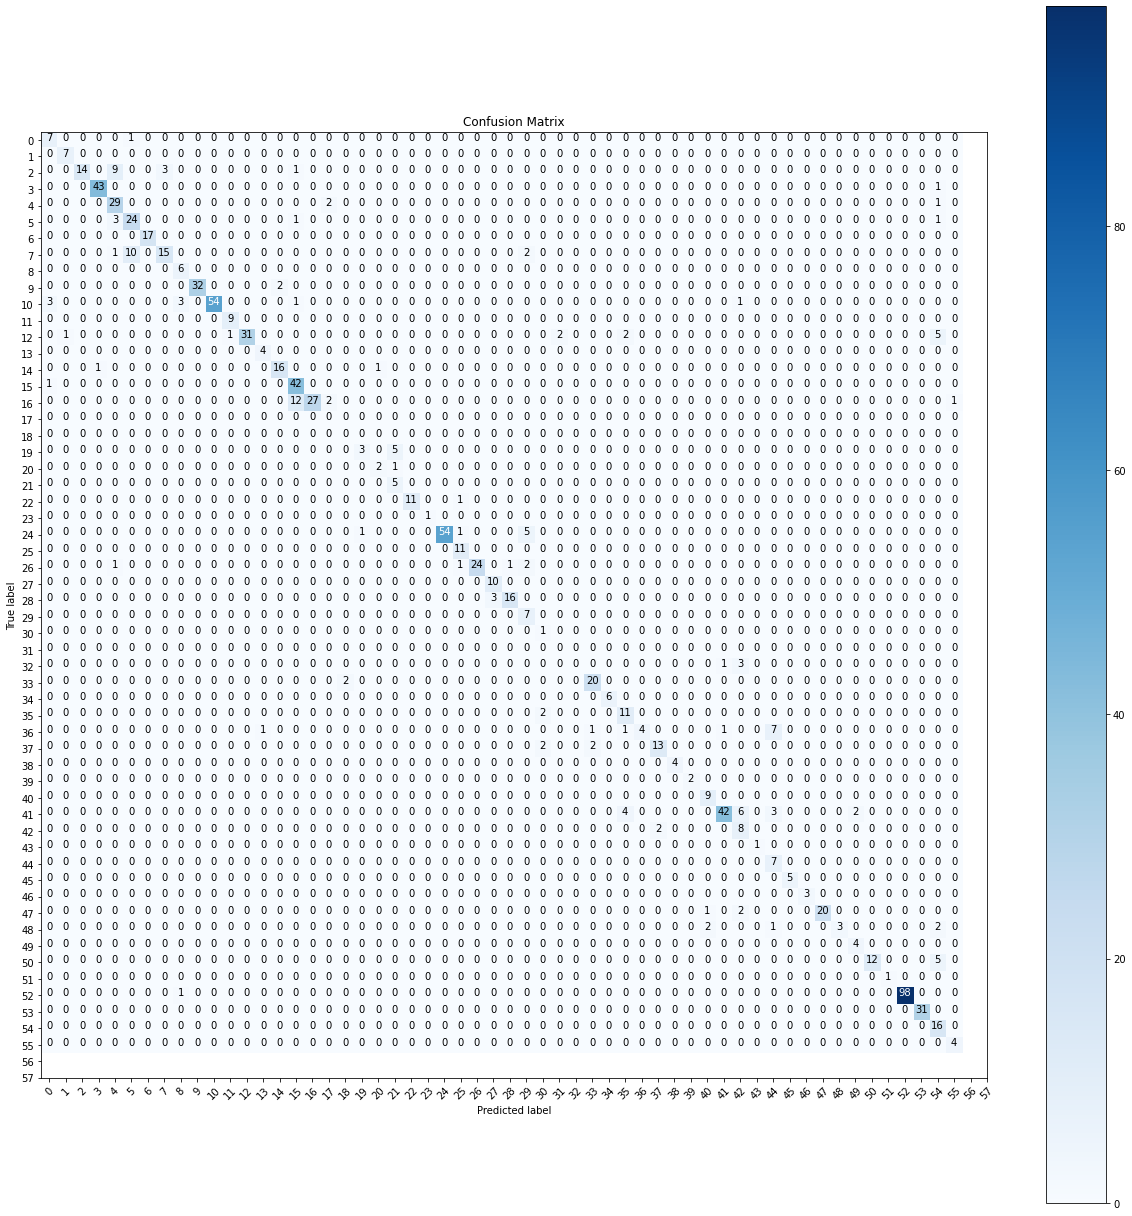

In [ ]:
cm = confusion_matrix(truth, prediction)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
print(classification_report(truth, prediction))

              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.88      1.00      0.93         7
           2       1.00      0.52      0.68        27
           3       0.98      0.98      0.98        44
           4       0.67      0.91      0.77        32
           5       0.69      0.83      0.75        29
           6       1.00      1.00      1.00        17
           7       0.83      0.54      0.65        28
           8       0.60      1.00      0.75         6
          10       1.00      0.94      0.97        34
          11       1.00      0.87      0.93        62
          12       0.90      1.00      0.95         9
          13       1.00      0.74      0.85        42
          14       0.80      1.00      0.89         4
          15       0.89      0.89      0.89        18
          16       0.74      0.98      0.84        43
          17       1.00      0.64      0.78        42
          19       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1